In [1]:
# https://keras.io/examples/vision/deeplabv3_plus/

In [2]:
# import the packages we need...
#first, the general stuff
#load up the basics
import os, pathlib, random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.9.1
 GPU: /device:GPU:0


In [3]:
#data pipeline
auto = tf.data.AUTOTUNE
num_classes = 4

imdim = 512
imsize = (imdim,imdim)

def load_data(path, val_split = 0.2):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "labels/*")))
    
    data = list(zip(images,masks))
    random.shuffle(data)
    
    split_index = int(len(data)*(1-val_split))
    train_data = data[:split_index]
    val_data = data[split_index:]
    
    train_images, train_labels = zip(*train_data)
    val_images, val_labels = zip(*val_data)

    return train_images, train_labels, val_images, val_labels

#this is a fn to make sure the doodler-derived labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

#standardization of images using adjusted standard deviation

def standardize(img):

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img)==2:
        img = np.dstack((img,img,img))

    return img

# custom 2d resizing functions for 2d discrete labels
def scale(im, nR, nC):
    nR0 = len(im)     # source number of rows
    nC0 = len(im[0])  # source number of columns
    tmp = [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]
            for c in range(nC)] for r in range(nR)]
    return np.array(tmp).reshape((nR,nC))

#reading the image
def read_image(path):
    x = imread(path)
    x = resize(x, imsize, anti_aliasing=False)
    x = standardize(x)
    x = x.astype(np.float32)
    return x

#reading the labels
def read_mask(path):
    y = imread(path)
    y = scale(y,imdim,imdim)

    y = D_Filter(y)
    

    #Label encoding
    y = np.expand_dims(y, axis=-1)
    y = y.astype(np.int32)

    # one hot encoding
    #y = np.eye(num_classes)[y]
    #y = y.astype(np.int32)
        
    return y

#the preprocessing code for images and labels
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    images.set_shape([imdim, imdim,3])
    
    
    #LABEL
    masks.set_shape([imdim, imdim,1])
    #one hot
    #masks.set_shape([512, 512, num_classes])
    

    return images, masks


#function to make a tf dataset object
def make_tfdataset(x, y, BATCH_SIZE = 4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    #dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess , num_parallel_calls = auto)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE) #, drop_remainder=True)
    dataset = dataset.prefetch(auto)

    return dataset


In [4]:
# make the dataset
path = ("../data/segmentation")
val_split = 0.2
batch = 4


train_images, train_labels, val_images, val_labels = load_data(path, val_split)

print(f"Train Images: {len(train_images)}, Train Labels: {len(train_labels)}")
print(f"Val Images: {len(val_images)}, Val Labels: {len(val_labels)}")


train_dataset = make_tfdataset(list(train_images), list(train_labels), batch)
val_dataset = make_tfdataset(list(val_images), list(val_labels), batch)

Train Images: 943, Train Labels: 943
Val Images: 236, Val Labels: 236


In [5]:
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>
Val Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>


In [6]:
image_count = 1015
batch_count = image_count/batch

val_size = int(batch_count * 0.2)
steps_per_epoch = int(len(train_images)/batch)
validation_steps = int(len(val_images)/batch)
print(steps_per_epoch)
print(validation_steps)

235
59


In [7]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output



In [8]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=imdim, num_classes=num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_add (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 128, 128, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 64, 64, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 64, 64, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 32, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 rmalization)                                                                                     
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 32, 32, 256)  1024       ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 32, 32, 256)  0           ['tf.nn.relu[0][0]']             
                                                                                                  
 tf.nn.relu_1 (TFOpLambda)      (None, 32, 32, 256)  0           ['batch_normalization_1[0][0]']  
                                                                                                  
 tf.nn.relu_2 (TFOpLambda)      (None, 32, 32, 256)  0           ['batch_normalization_2[0][0]']  
          

Epoch 1/25
235/235 [==============================] - 240s 955ms/step - loss: 0.6380 - accuracy: 0.7644 - val_loss: 1.8757 - val_accuracy: 0.4410
Epoch 2/25
235/235 [==============================] - 217s 928ms/step - loss: 0.4918 - accuracy: 0.8207 - val_loss: 1.2921 - val_accuracy: 0.4889
Epoch 3/25
235/235 [==============================] - 225s 960ms/step - loss: 0.4513 - accuracy: 0.8391 - val_loss: 0.9747 - val_accuracy: 0.6276
Epoch 4/25
235/235 [==============================] - 235s 1s/step - loss: 0.4220 - accuracy: 0.8460 - val_loss: 0.3681 - val_accuracy: 0.8693
Epoch 5/25
235/235 [==============================] - 223s 954ms/step - loss: 0.3864 - accuracy: 0.8591 - val_loss: 0.4161 - val_accuracy: 0.8440
Epoch 6/25
235/235 [==============================] - 215s 919ms/step - loss: 0.3670 - accuracy: 0.8692 - val_loss: 0.4250 - val_accuracy: 0.8514
Epoch 7/25
235/235 [==============================] - 224s 959ms/step - loss: 0.3491 - accuracy: 0.8764 - val_loss: 0.3395 - va

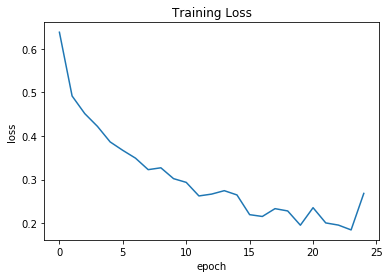

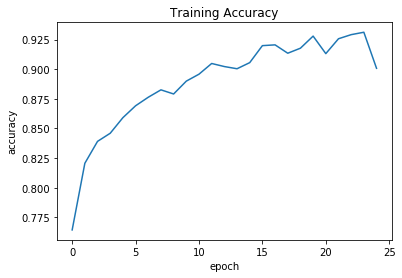

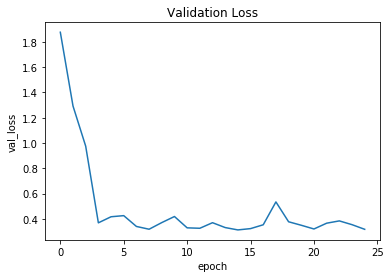

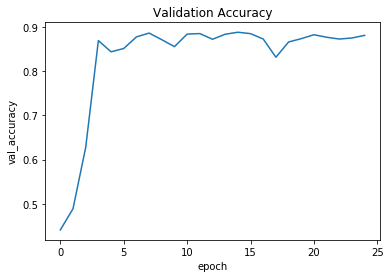

In [9]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, 
                    validation_data=val_dataset,
                    validation_steps =  val_size, steps_per_epoch = steps_per_epoch,
                    epochs=25)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


1/1 [==============================] - 0s 18ms/step


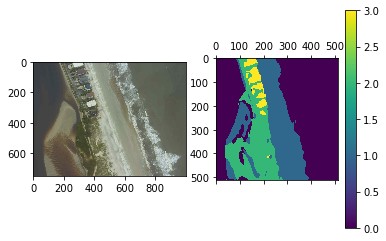

In [15]:
#lets look at the model prediction on a single image.

# here is the gdrive path to the image
imgp = '../data/segmentation/images/C26047791-1_L1.jpg'

#we pull the image and preprocess it — normalizing and making it a array/tensor
img = tf.keras.preprocessing.image.load_img(imgp,target_size = (imdim,imdim))
img = tf.keras.preprocessing.image.img_to_array(img)
img = standardize(img)
img = np.expand_dims(img,axis=0)

#We use the model to make a prediction on this image
pred = model.predict(img)

am_input = pred.squeeze()
lab = np.argmax(am_input,-1)


#lets look at the model results and the image

imgUP = matplotlib.image.imread(imgp)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imgUP)
labels = ax2.matshow(lab)
cax = fig.colorbar(labels, ax = ax2)
plt.show()

# water: 0; sand:1; veg : 2; dev : 3